### Deep FBA Trader model creation

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

In [2]:
root_folder_path = 'C:/Users/camer/Documents/Masters Thesis/Data/Training data/'
specific_folder = '1 sec batch full trading day'
folder_path = root_folder_path + specific_folder

data_sets = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        data_set = pd.read_csv(file_path)
        data_sets.append(data_set)

large_csv = pd.concat(data_sets, ignore_index=True)
large_csv.to_csv(f'{folder_path}/all_data.csv', index=False)
training_data = large_csv
training_data

,time_of_publish,bid_ask_spread,midprice,microprice,best_bid,best_ask,prev_batch_price,prev_batch_trade_qty,time_of_trade,final_trade_price
0,12.191940,43,21.5,0.000000,43,0,0.0,0,23.892929,73.50
1,23.892929,12,61.0,61.000000,55,67,73.5,1,35.522644,67.50
2,35.522644,13,74.5,74.290323,68,81,67.5,2,47.416580,103.50
3,47.416580,32,86.0,84.666667,70,102,103.5,3,57.417572,107.00
4,78.480972,17,92.5,91.650000,84,101,0.0,0,88.578369,84.00
...,...,...,...,...,...,...,...,...,...,...
41814120,28503.031586,0,0.0,0.000000,0,0,0.0,0,28513.986740,63.00
41814121,28567.040405,81,40.5,0.000000,0,81,0.0,0,28585.108932,75.00
41814122,28646.904007,55,27.5,0.000000,0,55,0.0,0,28658.418228,86.00
41814123,28694.755371,0,0.0,0.000000,0,0,0.0,0,28713.767487,61.50


In [3]:
training_data = pd.read_csv('C:/Users/camer/Documents/Masters Thesis/Data/Training data/1 sec batch full trading day/all_data.csv')

Prepping the training data for input

In [4]:
X = training_data.drop(columns=['final_trade_price', 'time_of_trade'])
y = training_data['final_trade_price']

X = X.values
y = y.values

X = X.reshape((X.shape[0], 1, X.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_2d = X_train.reshape((X_train.shape[0], X_train.shape[2]))
X_test_2d = X_test.reshape((X_test.shape[0], X_test.shape[2]))

X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

scaler_filename = 'scaler.joblib'
joblib.dump(scaler, scaler_filename)

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

X_train_scaled = X_train_scaled.astype(np.float16)
X_test_scaled = X_test_scaled.astype(np.float16)

Building the model

In [8]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), dtype=tf.float16))
model.add(LSTM(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train_scaled, y_train, epochs=1, validation_split=0.2, verbose=1)
test_loss = model.evaluate(X_test_scaled, y_test, verbose=1)

1072481/1072481 ━━━━━━━━━━━━━━━━━━━━ 5264s 5ms/step - loss: 379.7580 - val_loss: 331.9928
335151/335151 ━━━━━━━━━━━━━━━━━━━━ 968s 3ms/step - loss: 331.9485


Save model

In [9]:
model.save('Neural_network_models/1secbatch_model_simpler_archv1.keras')

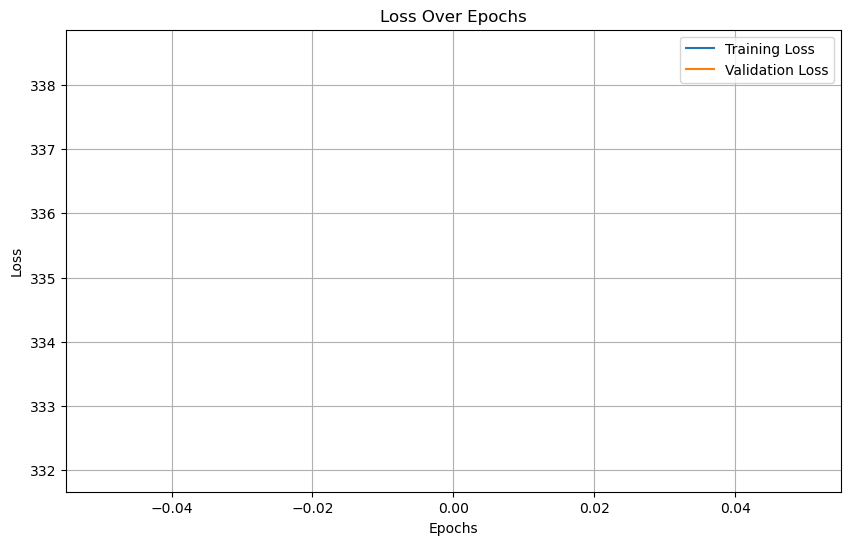

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()